# Volume 3: Kalman Filter
    <Name>
    <Class>
    <Date>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm

## Problem 1

Begin implementing a KalmanFilter class by writing an initialization method that stores the transition and observation models, noise covariances, and control vector.

## Problem 3

Add a method evolve() to your KalmanFilter class to generate a state and observation sequence by evolving the system from a given initial state.


## Problem 4
Add code to your KalmanFilter class to estimate a state sequence corresponding to a given observation sequence and initial state estimate by implementing the estimate() method.

## Problem 6

Add a function predict() to your class that predicts the next $k$ states given a current state estimate but in the absence of observations.

## Problem 8
Add a function rewind() to your class that rewinds the system from a given state estimate, returning predictions for the previous states. 

In [3]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        
        # Initialize the parameters
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        # Initialize the arrays to store states and observations
        states = []
        observations = []
        
        # Append x0
        states.append(x0)
        
        # Compute for time N
        for _ in range(N):
            # Append the different observations at a given time
            obs = self.H @ x0 + np.random.multivariate_normal(mean=[0,0], cov=self.R)
            observations.append(obs)
            # Append the different states at a given time
            x0 = self.F @ x0 + self.u + np.random.multivariate_normal(mean=[0,0,0,0], cov=self.Q)
            states.append(x0)
        
        # Return states and observations
        states = states[:-1]
        return np.array(states).T, np.array(observations).T
            
               

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        
        # Get shape, initialize array of state estimates
        m,N = z.shape
        state_estimates = []
        
        # Append x0
        state_estimates.append(x0)
        
        # Iterate through all the samples
        for k in range(N):
            # Predict
            x0 = self.F @ x0 + self.u
            P0 = self.F @ P0 @ self.F.T + self.Q
            
            # Update
            y = z[:, k] - self.H @ x0
            S = self.H @ P0 @ self.H.T + self.R
            K = P0 @ self.H.T @ inv(S) 
            x0 = x0 + K @ y
            P0 = (np.eye(K.shape[0])-K @ self.H) @ P0
            state_estimates.append(x0)
        
        # Cut off the last one
        state_estimates = state_estimates[:-1]
        
        # Return the array
        return np.squeeze(np.array([state_estimates]).T, axis = 2)
            
            
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # Initialize out array
        out_array = []
        
        # Predict k states
        for _ in range(k):
            x = self.F @ x + self.u
            out_array.append(x)
        
        # Return out array 
        return np.array(out_array).T
            
            
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        
        # Initialize out array
        out_array = []
        
        # Predict k states
        for _ in range(k):
            x = inv(self.F) @ (x - self.u)
            out_array.append(x)
        
        # Return out array
        return np.array(out_array).T


## Problem 2 

Work out the transition and observation models $F$ and $H$, along with the control vector $\mathbf{u}$, corresponding to the projectile. 
Assume that the noise covariances are given by 

$\begin{align*}
    Q &= 0.1 \cdot I_4 \\
    R &= 5000 \cdot I_2.
\end{align*}$

Instantiate a KalmanFilter object with these values.

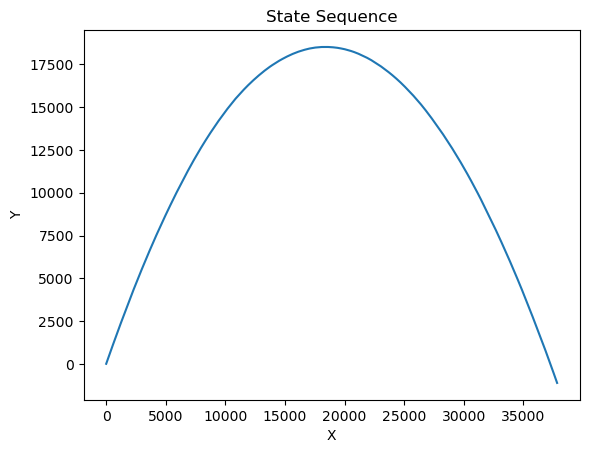

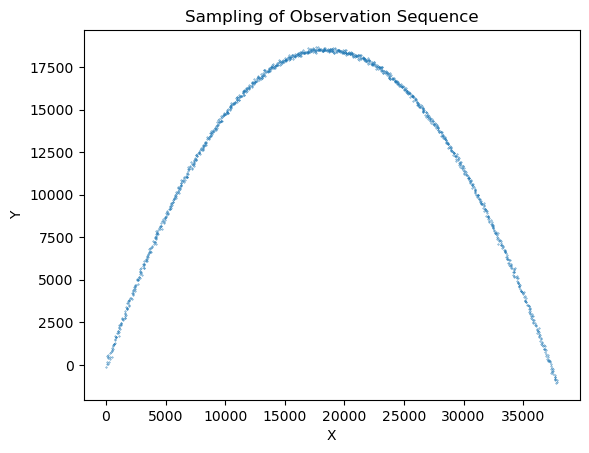

In [4]:
# Initialize the matrices and vectors
Q = 0.1 * np.eye(4)
R = 5000 * np.eye(2)
F = np.array([[1, 0, 0.1, 0], [0,1,0,0.1], [0,0,1,0], [0,0,0,1]])
u = np.array([0,0,0,-0.98])
H = np.array([[1,0,0,0], [0,1,0,0]])

# Set up Kalman Filter and get the states and observations
kf = KalmanFilter(F, Q, H, R, u)
states, observations = kf.evolve(np.array([0,0,300,600]), 1250)

# Pull out the state and observation values
x_states = states[0,:]
y_states = states[1,:]
x_observations = observations[0,:]
y_observations = observations[1,:]


# Plot data
plt.plot(x_states, y_states)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('State Sequence')
plt.show()
plt.scatter(x_observations, y_observations, s = 0.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sampling of Observation Sequence')
plt.show()

## Problem 3

Simulate the true and observed trajectory of a projectile with initial state

$\begin{equation*}
    x_0 = \left( \begin{array}{c} 0 \\ 0 \\ 300 \\ 600 \end{array} \right).
\end{equation*}$

## Problem 5

Calculate an initial state estimate $\hat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200. 
For the velocity, compute the average velocity between the observations $\mathbf{z}_k$ and $\mathbf{z}_{k+1}$ for $k = 200,\dots, 208$, then average these 9 values and take this as the initial velocity estimate.
Using the initial state estimate, $P_{200} = 10^6\cdot Q$, and your Kalman Filter, compute the next 600 state estimates, i.e. compute $\hat{\mathbf{x}}_{201},\dots,\hat{\mathbf{x}}_{800}$. 
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entire true state sequence (as
a blue curve). 
Zoom in to see how well it follows the true path. 

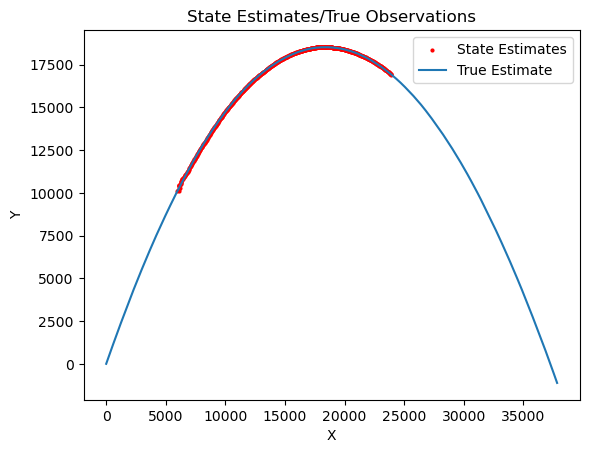

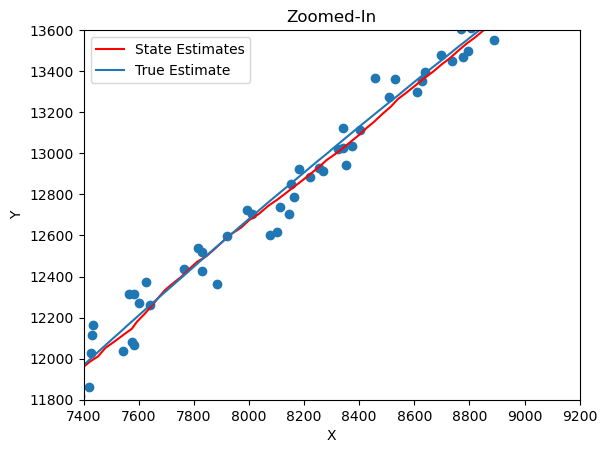

In [10]:
# Get values for initial state
horizontal_position = x_states[200]
vertical_position = y_states[200]
horizontal_velocity = float(np.mean(np.diff(x_states[200:209])))
vertical_velocity = float(np.mean(np.diff(y_states[200:209])))

# Initialize initial state and P estimate
initial_state_estimate = np.array([horizontal_position, vertical_position, horizontal_velocity, vertical_velocity])
P_estimate = 10e6 * Q

# Estimate states (and x and y estimates)
state_estimates = kf.estimate(initial_state_estimate, P_estimate, observations[:,201:801])
x_estimates = state_estimates[0,:]
y_estimates = state_estimates[1,:]

# Plot values
plt.scatter(x_estimates, y_estimates, s = 4,  color = 'red', label = 'State Estimates')
plt.plot(x_states, y_states, label = 'True Estimate')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('State Estimates/True Observations')
plt.legend()
plt.show()

# Plot in the zoomed in values
plt.plot(x_estimates, y_estimates, color = 'red', label = 'State Estimates')
plt.plot(x_states, y_states, label = 'True Estimate')
plt.scatter(x_observations, y_observations)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(7400, 9200)
plt.ylim(11800, 13600)
plt.title('Zoomed-In')
plt.legend()
plt.show()

## Problem 7

Using the final state estimate $\hat{\mathbf{x}}_{800}$ that you obtained in Problem 5, predict the future states of the projectile until it hits the ground. 
Predicting approximately the next 450 states should be sufficient.
Plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.

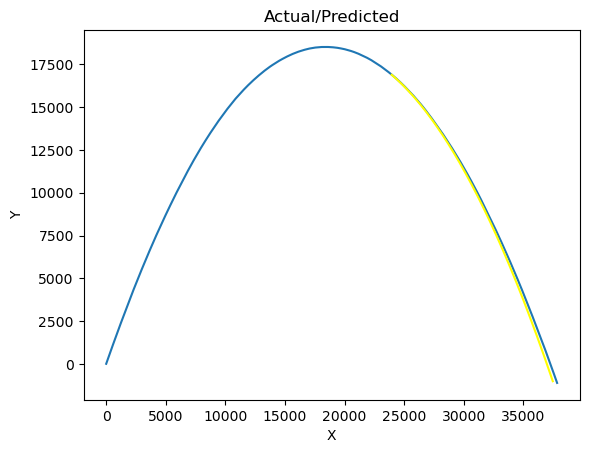

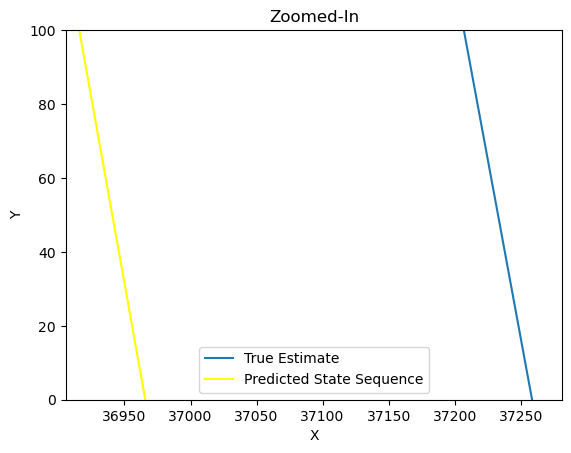

In [16]:
# Get final state estimate
final_state_estimate = state_estimates[:,-1]

# Predict the future state estimates
future_state_estimates = kf.predict(final_state_estimate, 450 )

# Get x futures and y futures
x_futures = future_state_estimates[0,:]
y_futures = future_state_estimates[1,:]

# Plot data
plt.plot(x_states, y_states, label = 'True Estimate')
plt.plot(x_futures, y_futures, color = 'yellow', label = 'Predicted State Sequence')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual/Predicted')
plt.show()

# Plot in the zoomed in values
plt.plot(x_states, y_states, label = 'True Estimate')
plt.plot(x_futures, y_futures, color = 'yellow' , label = 'Predicted State Sequence')
plt.scatter(x_observations, y_observations)
plt.xlabel('X')
plt.ylabel('Y')
x1 = x_states[np.where(y_states >=0)][-1]
x2 = x_futures[np.where(y_futures >=0)][-1]
plt.xlim(min(x1,x2)-50, max(x1,x2)+50)
plt.ylim(0, 100)
plt.title('Zoomed-In')
plt.legend()
plt.show()


## Problem 9

Using your state estimate $\hat{\mathbf{x}}_{250}$, predict the point of origin of the projectile along with all states leading up to time step 250. 
Note that you may have to take a few extra time steps to predict the point of origin. 
Plot these predicted states (in green) together with the original state sequence. 
Zoom in to see how accurate your prediction is. 
Repeat the prediction starting with $\hat{\mathbf{x}}_{600}$. 
Compare to the previous results. 
Which is better? 
Why?

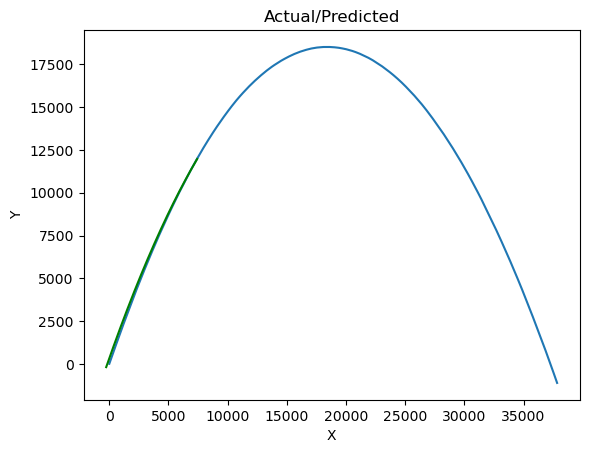

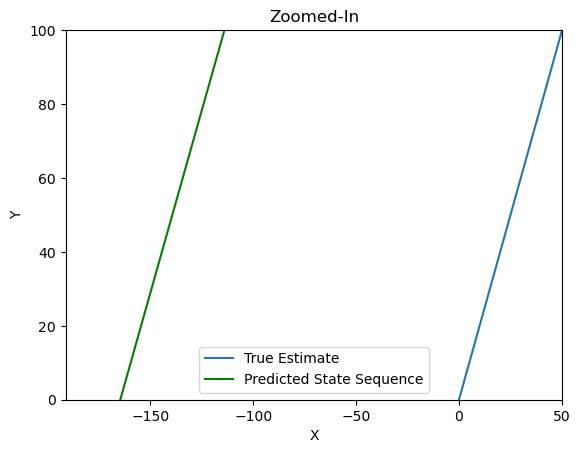

In [19]:
# Get state estimate to predict point of origin
needed_state_estimate = state_estimates[:,50]

# Get past estimates
past_estimates = kf.rewind(needed_state_estimate, 253)

# Get x past and y past
x_past = past_estimates[0,:]
y_past = past_estimates[1,:]

# Plot data
plt.plot(x_states, y_states, label = 'True Estimate')
plt.plot(x_past, y_past, color = 'green', label = 'Past Estimates')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Actual/Predicted')
plt.show()

# Plot in the zoomed in values
plt.plot(x_states, y_states, label = 'True Estimate')
plt.plot(x_past, y_past, color = 'green' , label = 'Predicted State Sequence')
plt.scatter(x_observations, y_observations)
plt.xlabel('X')
plt.ylabel('Y')
x1 = 0
x2 = x_past[np.where(y_past >=0)][-1]
plt.xlim(min(x1,x2)-50, max(x1,x2)+50)
plt.ylim(0, 100)
plt.title('Zoomed-In')
plt.legend()
plt.show()
